In [2]:
import os
import csv
import yaml

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd

In [15]:
pd.__version__
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80

In [4]:
AARM_DEVICES = {
    "jetson_cpu": "Nvidia Jetson CPU Only",
    "jetson_gpu": "Nvidia Jetson GPU Enabled", 
    # "rpi4_cpu": "Raspberry Pi 4B"
} # pi3_cpu

x86_DEVICES= {
    "herron_cpu": "Server Intel Xeon",
    "herron_gpu": "Server Nvidia RTX-8000",
    "laptop_cpu": "Laptop Intel-i7 (8th Generation)"
}

DEVICE_LIST = {**x86_DEVICES, **AARM_DEVICES}

SEQ_LENGTHS = [2 ** seqlen for seqlen in range(10)]

In [5]:
BASELINE_TRANSFORMERS = {
    "bert": "BERT-Base",
    "roberta": "RoBERTa"
}

OTHER_TRANSFORMERS = {
    'longformer': "Longformer", 
    'deberta': "DeBERTa",
    'albert': "Albert",
    'ibert': "ibert"
}

EFFICIENT_TRANSFORMERS = {
    'albert': "Albert",
    "distilbert": "DistilBERT",
    "mobile_bert": "MobileBERT",
    "squeeze_bert": "SqueezeBERT",
    "funnel_transformer": "Funnel Transformer"
}

In [6]:
BASELINE_VISUAL = {
    "resnet18": "ResNet-18",
    "vit32": "ViT32",
}

OTHER_VISUAL = {
    "alexnet": "AlexNet",
    "vgg16": "VGG16",
    "densenet": "DenseNet",
    "inception": "InceptionNet",
    "googlenet": "GoogLeNet",
    "resnext50_32x4d": "ResNext50",
    "wide_resnet50_2": "Wide ResNet-50"
}

EFFICIENT_VISUAL = {
    "efficientnet": "EfficientNet",
    "efficientnet_lite": "EfficientNet Lite",
    "gernet": "GErNet", 
    "shufflenet": "ShuffleNet",
    "squeezenet": "SqueezeNet", 
    "mobilenet_v2": "MobileNet v2",
    "mnasnet": "MNAS Net"
    }

In [7]:
VISUAL_DIR = "experiments/pretrained/0903_vision"
LANGUAGE_DIR = "experiments/pretrained/0903_transformers"
SEQLEN_BASELINE_DIR = "experiments/templates/1208_template_seqlen"
LAYER_BASELINE_DIR = "experiments/templates/1208_template_layers"

seqlen_baseline = pd.concat([
    pd.read_csv(os.path.join(SEQLEN_BASELINE_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

layer_baseline = pd.concat([
    pd.read_csv(os.path.join(LAYER_BASELINE_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

vision_results = pd.concat([
    pd.read_csv(os.path.join(VISUAL_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

language_results = pd.concat([
    pd.read_csv(os.path.join(LANGUAGE_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

all_results = pd.concat([vision_results, language_results])

In [8]:
device_specs = {}
for device in DEVICE_LIST:
    device_specs[device] = yaml.load(open(f"config/devices/specs/{device}.yaml", "rb"))
 

/home/jaredfern/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
LANGUAGE_MODELS = {**EFFICIENT_TRANSFORMERS, **BASELINE_TRANSFORMERS} # **OTHER_TRANSFORMERS }
VISION_MODELS = {**BASELINE_VISUAL, **EFFICIENT_VISUAL, }


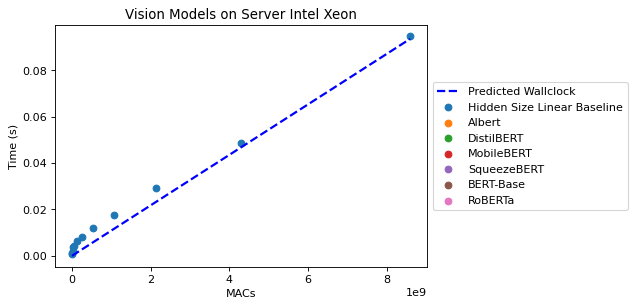

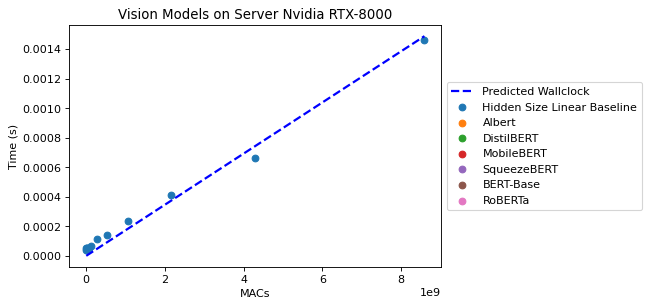

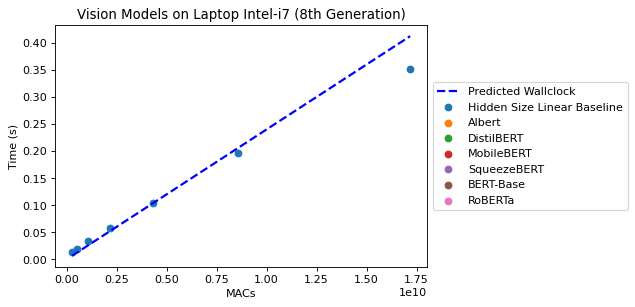

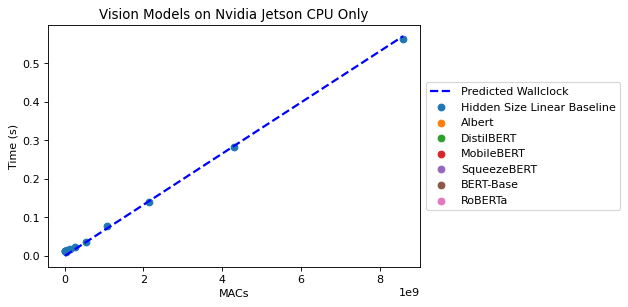

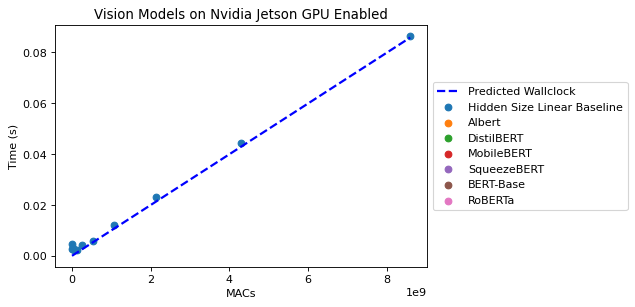

In [20]:
linear_coeffs = {}
for MODELS in [LANGUAGE_MODELS]:
    for device, device_name in DEVICE_LIST.items():
        device_seqlen = seqlen_baseline.loc[seqlen_baseline['device'] == device]
        avg_memory = np.array(device_seqlen['avg_memory']).reshape(-1, 1)
        mac_result = np.array(device_seqlen['macs']).reshape(-1, 1)
        wallclock_result = np.array(device_seqlen['latency']).reshape(-1, 1)
        param_count = np.array(device_seqlen['total_params']).reshape(-1, 1)

        linear_model = LinearRegression(fit_intercept=False).fit(mac_result, wallclock_result)
        linear_coeffs[device] = linear_model.coef_[0][0]
        wallclock_predicted = linear_model.predict(mac_result)

        plt.scatter(mac_result[:-1], wallclock_result[:-1], label="Hidden Size Linear Baseline")
        plt.plot(mac_result[:-1], wallclock_predicted[:-1], "b--", label="Predicted Wallclock", linewidth=2)

        # device_layer = layer_baseline.loc[layer_baseline['device'] == device]
        # avg_memory = device_layer['avg_memory'].tolist()
        # mac_result = device_layer['macs'].tolist()
        # wallclock_result = device_layer['latency']
        # param_count = device_layer['total_params'].tolist()
        # plt.scatter(mac_result, wallclock_result, label="Layer Linear Baseline")
        # plt.plot(mac_result, wallclock_result)

        for model, model_name in MODELS.items():
            if model_name == "Funnel Transformer": continue
            results = all_results.loc[all_results['device'] == device]
            results = results.loc[results['img_size'] == 224]
            seq_lens = results.loc[results['model'] == model]['sequence_length'].tolist()
            img_size = results.loc[results['model'] == model]['img_size'].tolist()
            avg_memory = results.loc[results['model'] == model]['avg_memory'].tolist()
            mac_result = results.loc[results['model'] == model]['macs'].tolist()
            wallclock_result = results.loc[results['model'] == model]['mean']
            param_count = results.loc[results['model'] == model]['total_params'].tolist()

            x_ax, x_label = mac_result, "MACs"
            y_ax, y_label = wallclock_result, "Time (s)"

            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.scatter(x_ax, y_ax, label=f"{model_name}")  
            plt.plot(x_ax,y_ax)

        plt.title(f"Vision Models on {device_name}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [68]:
angles = {device: np.arctan(linear_coeffs[device]) for device in DEVICE_LIST}


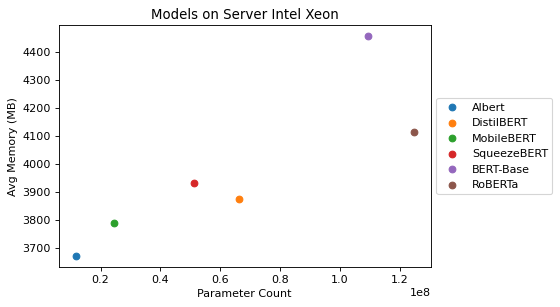

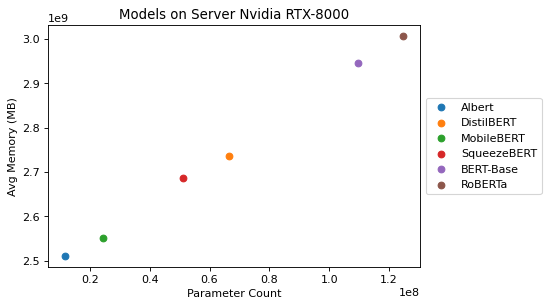

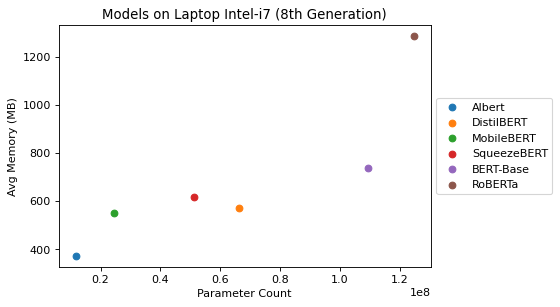

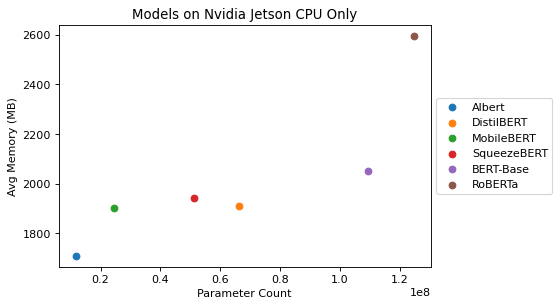

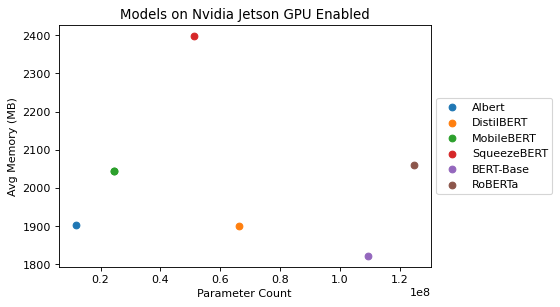

In [26]:
for MODELS in [{**LANGUAGE_MODELS}]:
    for device, device_name in DEVICE_LIST.items():
        device_seqlen = seqlen_baseline.loc[seqlen_baseline['device'] == device]
        avg_memory = np.array(device_seqlen['avg_memory']).reshape(-1, 1)
        mac_result = np.array(device_seqlen['macs']).reshape(-1, 1)
        wallclock_result = np.array(device_seqlen['latency']).reshape(-1, 1)
        param_count = np.array(device_seqlen['total_params']).reshape(-1, 1)

        # linear_model = LinearRegression(fit_intercept=False).fit(mac_result, wallclock_result)
        # linear_coeffs[device] = linear_model.coef_[0][0]
        # wallclock_predicted = linear_model.predict(mac_result)

        # plt.scatter(mac_result[:-1], wallclock_result[:-1], label="Hidden Size Linear Baseline")
        # # plt.plot(mac_result[:-1], wallclock_result[:-1], "b-")
        # plt.plot(mac_result, wallclock_predicted, "b--", label="Predicted Wallclock", linewidth=2)

        # device_layer = layer_baseline.loc[layer_baseline['device'] == device]
        # avg_memory = device_layer['avg_memory'].tolist()
        # mac_result = device_layer['macs'].tolist()
        # wallclock_result = device_layer['latency']
        # param_count = device_layer['total_params'].tolist()
        # plt.scatter(mac_result, wallclock_result, label="Layer Linear Baseline")
        # plt.plot(mac_result, wallclock_result)

        # print(angles[device])
        for model, model_name in MODELS.items():
            if model_name == "Funnel Transformer": continue
            results = all_results.loc[all_results['device'] == device]
            # results = results.loc[results['img_size'] == 224]
            results = results.loc[results['sequence_length'] == 128]

            seq_lens = results.loc[results['model'] == model]['sequence_length'].tolist()
            img_size = results.loc[results['model'] == model]['img_size'].tolist()
            avg_memory = results.loc[results['model'] == model]['avg_memory'].tolist()
            mac_result = results.loc[results['model'] == model]['macs'].tolist()
            wallclock_result = results.loc[results['model'] == model]['mean']
            param_count = results.loc[results['model'] == model]['total_params'].tolist()

            x_ax, x_label = param_count, "Parameter Count"
            y_ax, y_label = avg_memory, "Avg Memory (MB)"
            # x_ax, x_label = mac_result, "MACs"
            # y_ax, y_label = wallclock_result, "Time (s)"
            # model_angle = np.arctan(y_ax/ x_ax)
            # print(model_angle)

            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.scatter(x_ax, y_ax, label=f"{model_name}")  
            plt.plot(x_ax,y_ax)

        plt.title(f"Models on {device_name}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()